In [1]:
from transformers import SpeechT5ForSpeechToText, SpeechT5Processor
from genaibook.core import get_device

In [2]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_asr")
model = SpeechT5ForSpeechToText.from_pretrained("microsoft/speecht5_asr")

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/606M [00:00<?, ?B/s]

SpeechT5ForSpeechToText has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of SpeechT5ForSpeechToText were not initialized from the model checkpoint at microsoft/speecht5_asr and are newly initialized: ['speecht5.encod

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/606M [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset
ds = load_dataset(
    "openslr/librispeech_asr",
    split="train.clean.360",
    streaming=True
)

sample = next(iter(ds))
sample
array = sample["audio"]['array']
sampling_rate = sample['audio']['sampling_rate']

array = array[: sampling_rate * 5]

In [4]:
import torch

In [5]:
inputs = processor(
    audio=array, sampling_rate=sampling_rate, return_tensors="pt"
)
with torch.inference_mode():
    predicted_ids = model.generate(**inputs, max_new_tokens=70)

In [6]:
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
print(transcription)

['the second and importance is as follows sovereignty may be defined to']


In [7]:
## Define the speaker with online speaker embedding
from transformers import SpeechT5ForTextToSpeech
from genaibook.core import get_speaker_embeddings

In [8]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

In [9]:
inputs = processor(text="They'll say aw topsy at my autopsy", return_tensors="pt")
speaker_embeddings = torch.tensor(get_speaker_embeddings()).unsqueeze(0)

In [10]:
with torch.inference_mode():
    spectrogram = model.generate_speech(inputs['input_ids'], speaker_embeddings)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

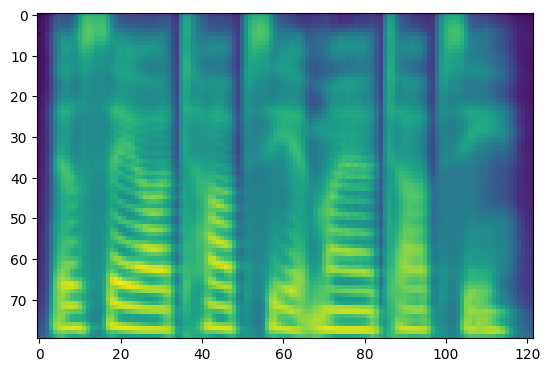

In [12]:
plt.figure()
plt.imshow(np.rot90(np.array(spectrogram)))
plt.show()

In [13]:
# Above is not enough to generate speech - need vocoder to get phase in addition to pitch and amplitude
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
with torch.inference_mode():
    speech = vocoder(spectrogram)

In [14]:
import IPython.display as ipd
ipd.Audio(data=speech, rate=sampling_rate)

In [15]:
# Multilingual models
from transformers import VitsModel, VitsTokenizer, set_seed

In [16]:
tokenizer = VitsTokenizer.from_pretrained("facebook/mms-tts-eng")
model = VitsModel.from_pretrained("facebook/mms-tts-eng")

inputs = tokenizer(text="The rain in Spain stays mainly in the plan", return_tensors="pt")

In [17]:
set_seed(555)
with torch.inference_mode():
    outputs = model(inputs["input_ids"])

In [18]:
outputs.waveform[0]

tensor([-7.2436e-07, -3.8982e-05, -3.3968e-05,  ...,  5.7543e-05,
         3.0920e-05, -1.6344e-05])

In [19]:
ipd.Audio(data=outputs.waveform[0], rate=sampling_rate)

In [20]:
tokenizer = VitsTokenizer.from_pretrained("facebook/mms-tts-por")
model = VitsModel.from_pretrained("facebook/mms-tts-por")

In [21]:
# Portuguese - "I love you very much dearest, love of my life"
inputs = tokenizer(text="Te amo muito meu amor, amor de minha vida", return_tensors="pt")
set_seed(555)
with torch.inference_mode():
    outputs = model(inputs["input_ids"])

outputs.waveform[0]
ipd.Audio(data=outputs.waveform[0], rate=sampling_rate)

### Other Supported Languages:
[Documentation](https://dl.fbaipublicfiles.com/mms/misc/language_coverage_mms.html)

In [22]:
tokenizer = VitsTokenizer.from_pretrained("facebook/mms-tts-hak")
model = VitsModel.from_pretrained("facebook/mms-tts-hak")

# Means "Nice to meet you" in Hakka Chinese
inputs = tokenizer(text="Hên gô-sin thòi to ngî.", return_tensors="pt")
set_seed(555)
with torch.inference_mode():
    outputs = model(inputs["input_ids"])

outputs.waveform[0]
ipd.Audio(data=outputs.waveform[0], rate=sampling_rate)

In [ ]:
# Bark - Beyond Speech (i.e. music, laughing, sound effects)
# BROKEN BECAUSE TIMM AND TRANSFORMERS BROKEN SAD FACE
from transformers import AutoModel, AutoProcessor

device = get_device()
processor = AutoProcessor.from_pretrained("suno/bark-small")
model = AutoModel.from_pretrained("suno/bark-small").to(device)

inputs = processor(
    text=[
        """Hello, my name is Suno. And, uh -- and I like pizza. [laughs] But I also have other interests such as playing tic tac toe and WORLD DOMINATION"""
    ],
    return_tensors="pt"
).to(device)

speech_values = model.generate(**inputs, do_sample=True)
ipd.Audio(data=speech_values, rate=sampling_rate)

# If this block were working, we could change the predefined speaker voice:
voice_preset = "v2/en_speaker_6"
inputs = processor("How many toothpicks on the ground?")
audio_array = model.generate(**inputs.to(device))
audio_array = audio_array.cpu().numpy().squeeze()